In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoLars, BayesianRidge, TweedieRegressor, ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

from RegEnsemble import EnsembleRegressor


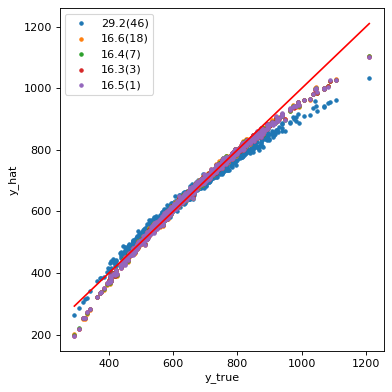

In [3]:
# data
n_samples, n_features, n_informative = 1000, 100, 20
X, y = make_regression(n_samples=n_samples, 
                       n_features=n_features, 
                       n_informative=n_informative, 
                       random_state=10)
maxabs = np.max(abs(y))
y = np.log(1 + np.exp(y/maxabs))*maxabs

# preparing base estimators
n_estimators = n_features//2
np.random.seed(0)
pool = [Ridge(), Lasso(), LinearRegression(), ElasticNet(), LassoLars(), BayesianRidge(), TweedieRegressor()]
estimators = []
for _ in range(n_estimators):
    estimators.append(clone(np.random.choice(pool, 1)[0]))

# define model
mdl = EnsembleRegressor(estimator = estimators,
                        n_estimators = n_estimators,
                        k_top_models = int(0.9*n_estimators),
                        frac_random_samples = 0.8,
                        frac_random_features = 0.8,
                        random_state = 42)

# in-bag training data and out-of-bag testing data
n_inb = n_samples//4
Xinb, yinb = X[:n_inb, :], y[:n_inb]
Xoob, yoob = X[n_inb:, :], y[n_inb:]

# fit the model, predict the model, evaluate, then enhance and compare enhancement
plt.subplots(figsize = (5,5), dpi = 80)
mdl.fit(Xinb, yinb)
yh = mdl.predict(Xoob)
rmse = mean_squared_error(yoob, yh, squared = False)
n_es = sum(np.array(mdl.model_weights_) > 0)
plt.scatter(yoob, yh, marker = '.', label = str(round(rmse,1)) + "("+str(n_es) + ")")
for i in range(4):
    mdl.enhance(0.6)
    yh = mdl.predict(Xoob)
    rmse = mean_squared_error(yoob, yh, squared = False)
    n_es = sum(np.array(mdl.model_weights_) > 0)
    plt.scatter(yoob, yh, marker = '.', label = str(round(rmse,1)) + "("+str(n_es) + ")")
plt.legend()
plt.plot([min(y), max(y)], [min(y), max(y)], 'r-')
plt.xlabel('y_true')
plt.ylabel('y_hat')
plt.tight_layout()
plt.show()